<a href="https://colab.research.google.com/github/deepakri201/MICCAI-educational-challenge-2023/blob/main/MICCAI_educational_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MICCAI Educational Challenge 2023

---
---

## Overview

This Colaboratory notebook accompanies the Medium article [Exploring AI-derived annotations in Imaging Data Commons (IDC)](https://medium.com/@deepa.krishnaswamy2/exploring-ai-derived-annotations-in-imaging-data-commons-idc-v2-2a2e1f42bf16), in submission for the [MICCAI Educational Challenge 2023](https://miccai-sb.github.io/challenge).

One of the issues with AI model development is how to validate you results when you do not have expert annotations. In this article, we demonstrate how to interact with segmentation results, by analyzing distributions of shape features and linking to a viewer.  Along the way, we introduce Imaging Data Commons, a cloud-based platform for cancer imaging data, as well as features of Google Cloud Platform that enable interactive analysis using dashboard and retrieving/querying of data.

We focus on the segmentation results in [this paper](https://arxiv.org/abs/2306.00150), where we generated AI-derived annotations of lung cancer imaging datasets. In this manuscript one of the pre-trained AI models was used to generate segmentations of thoracic organs-at-risk.

---

Deepa Krishnaswamy, Andrey Fedorov

Brigham and Women's Hospital

August 7th, 2023

# Prerequisites

Before beginning, please make sure you have a Google account.

Next, please complete the [tutorial to setup the prerequisites](https://github.com/ImagingDataCommons/IDC-Tutorials/blob/master/notebooks/getting_started/part1_prerequisites.ipynb).

In [ ]:
#@title Enter your Project ID here
# initialize this variable with your Google Cloud Project ID!
project_name = "idc-external-018" #@param {type:"string"}

import os
os.environ["GCP_PROJECT_ID"] = project_name

!gcloud config set project $project_name

from google.colab import auth
auth.authenticate_user()

Updated property [core/project].


# Functions

This function is used for creating figures using bokeh

In [ ]:
def color_list_generator(df, col):
  """

  Create a list of colors per col given a dataframe

  Arguments:
    df    : dataframe to get data from
    col   : column to use to get unique treatments.

  Returns:
    colormap   : the colormap created
    colors     : the actual colors

  Inspired by creating colors for each treatment
  Rough Source: http://bokeh.pydata.org/en/latest/docs/gallery/brewer.html#gallery-brewer
  Fine Tune Source: http://bokeh.pydata.org/en/latest/docs/gallery/iris.html

  """

  if (len(df[col].unique()))==1:
    colors = brewer["Dark2"][3][0:1] # Spectral, Dark2
  elif (len(df[col].unique()))==2:
    colors = brewer["Dark2"][3][0:2]
  elif (len(df[col].unique()))>8:
    num_colors = len(df[col].unique())
    num_colormaps = np.int32(np.ceil(num_colors/8))
    colormap_chained = brewer["Dark2"][8]*num_colormaps
    colors = colormap_chained[0:num_colors]
  else:
    colors = brewer["Dark2"][len(df[col].unique())]

  # Create a map between treatment and color.
  colormap = {i: colors[k] for k,i in enumerate(df[col].unique())}

  # sort these according to the key
  colormap = collections.OrderedDict(sorted(colormap.items()))

  # Return a list of colors for each value that we will be looking at.
  return colormap, [colormap[x] for x in df[col]]

# Install and import packages

In [ ]:
# These are used for reading/writing DICOM files
!pip install pydicom
!pip install pydicom-seg

# For using ITKwidgets
!pip install --upgrade --pre -q "itk==5.3.0"
!pip install 'itkwidgets>=1.0a23'
!pip install imjoy-elfinder
!pip install ipywidgets==8.0.3

# SimpleITK
!pip install SimpleITK

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 7.3 MB/s eta 0:00:00
  Attempting uninstall: jsonschema
    Found existing installation: jsonschema 4.3.3
    Uninstalling jsonschema-4.3.3:
      Successfully uninstalled jsonschema-4.3.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.6/25.6 MB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 56.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# General imports
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import SimpleITK as sitk
import pandas as pd
import random
import collections
import time
import shutil

# Google cloud specific packages
from google.cloud import bigquery
from google.cloud import storage

# Reading/writing DICOM files
import pydicom
import pydicom_seg

# ITKWidgets
import itk
from itkwidgets import view
from scipy import ndimage

# Plotting using bokeh
from bokeh.models import ColumnDataSource, OpenURL, TapTool
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.colors import RGB
from bokeh.transform import jitter
from bokeh.models import HoverTool, PanTool, WheelZoomTool, BoxZoomTool, ResetTool, TapTool
from bokeh.models import Legend, LegendItem
from bokeh.palettes import brewer
from bokeh.layouts import row
from bokeh.io import export_png
from bokeh.io.export import get_screenshot_as_png

In [ ]:
# Install dicomsort, a package for sorting DICOM files into different folders

# %%capture
start_time=time.time()

# FIXME: see if we can convert this to a package as well
# dicomsort
if os.path.isdir('/content/src/dicomsort'):
  try:
    shutil.rmtree('/content/src/dicomsort')
  except OSError as err:
    print("Error: %s : %s" % ("dicomsort", err.strerror))
# !git clone https://github.com/pieper/dicomsort.git
!git clone https://github.com/pieper/dicomsort.git src/dicomsort

Cloning into 'src/dicomsort'...
remote: Enumerating objects: 169, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 169 (delta 23), reused 33 (delta 16), pack-reused 126
Receiving objects: 100% (169/169), 87.84 KiB | 2.25 MiB/s, done.
Resolving deltas: 100% (86/86), done.


# Feature comparison of different regions for NLST


As described in the [publication](https://arxiv.org/abs/2306.00150) in arxiv, we focused on enhancing annotations of patients in lung cancer computed tomography (CT) datasets. We analyzed the National Lung Screening Trial (NLST) and NSCLC-Radiomics datasets, where only NSCLC-Radiomics has some expert annotations provided. We used a pre-trained nnU-Net model to segment thoracic organs-at-risk, which include the heart, aorta, trachea and esophagus.

Since we did not have expert annotations to compare to for NLST, we needed a way to quickly and efficiently examine the results of segmentations, and investigate any outliers. For this we extracted shape features from each of the regions, and looked at distributions of these values.

Here we pick a single feature (sphericity), and look at the distribution of this feature across all four regions. We show how to:

*   Query metadata in IDC using BigQuery (similar to SQL) to get the data we need
*   Use the python package bokeh to create an interactive plot that will open up the IDC portal where you can view the data

Let's get started!

---


In this query below, we first get all the data that has the sphericity feature. Then, we get additional data that's needed to view each patient in the IDC portal, and join these data together for the NLST collection. We convert the results to a pandas dataframe for ease of use and for plotting.

In [ ]:
# Query to get a single feature for all series for a single region

client = bigquery.Client(project=project_name)
table_id = ".".join(['bigquery-public-data', 'idc_v13', 'quantitative_measurements'])
print(table_id)

query = f"""
  WITH features AS (
    -- Select the data that includes the sphericity measurement
    -- Include the series it is derived from and the corresponding region
    SELECT
      sourceSegmentedSeriesUID,
      SOPInstanceUID,
      SeriesDescription,
      -- the region - e.g. heart, trachea, aorta, esophagus
      findingSite.CodeMeaning as region,
      -- the value of the feature of interest
      Value
    FROM
      -- IDC table to query from that holds metadata in the form of quantitative measurements
      `bigquery-public-data.idc_v13.quantitative_measurements`
    WHERE
      -- feature to retrieve data for
      Quantity.CodeMeaning = "Sphericity"
  )

  -- Select additional fields from the main dicom_all table, including the portal url
  SELECT
    DISTINCT(features.sourceSegmentedSeriesUID),
    features.SOPInstanceUID,
    dicom_all.StudyInstanceUID,
    dicom_all.PatientID,
    features.SeriesDescription,
    features.region,
    features.Value,
    CONCAT("https://viewer.imaging.datacommons.cancer.gov/viewer/",dicom_all.StudyInstanceUID) as viewer_url

  FROM
    features
  LEFT JOIN
    -- dicom_all is the main IDC table that contains the metadata extracted from the DICOM objects
    `bigquery-public-data.idc_v13.dicom_all` as dicom_all
  ON
    -- join the two above temporary tables on this field
    features.sourceSegmentedSeriesUID = dicom_all.SeriesInstanceUID
  WHERE
    -- only include data from the NLST collection
    dicom_all.collection_id = "nlst"
  ORDER BY
    -- specifies the ordering of the data returned
    dicom_all.PatientID,
    features.sourceSegmentedSeriesUID
"""

job_config = bigquery.QueryJobConfig(query_parameters=[
                                                       bigquery.ScalarQueryParameter("region", "STRING", region)
                                                       ])
df_plot = client.query(query, job_config=job_config).to_dataframe()

bigquery-public-data.idc_v13.quantitative_measurements


Now we use the python package `bokeh`, which allows us to create an interactive plot across the 4 regions for the feature we're interested in. You can click on any point in this plot, which will open up the patient in the IDC portal!

In [ ]:
# set the seed so jitter will be the same for each run
np.random.seed(0)
random.seed(0)

#--- create df of the feature we want to plot ---#

new_column = [np.float32(f) for f in df_plot['Value'].values]
df_plot['Value_numeric'] = new_column

# sort the rows
df_plot = df_plot.sort_values(by=['region']) # want alphabetical order

#### for each feature ###

# Get a color for each region
colormap, colors = color_list_generator(df_plot, 'region')
df_plot['colors'] = colors
colormap_list_keys = list(colormap.keys())
regions = colormap_list_keys

colors = list(colormap.values())

hover = HoverTool(tooltips=[
    ("(Value)", "($y)")
])

wZoom = WheelZoomTool()
bZoom = BoxZoomTool()
reset = ResetTool()
tap = TapTool()
pan = PanTool()

# cats = list(df_plot.region.unique()) # had to add list to this.
cats = regions

cats2 = []
for c in range(0,len(cats)):
  cats2.append(cats[c])
  cats2.append(cats[c]+"_boxplot")
regions = cats2

colors2 = []
for c in range(0,len(colors)):
  colors2.append(colors[c])
  colors2.append(colors[c])

# regions are in order we want
p = figure(tools = [hover, wZoom, bZoom, reset, tap, pan],
          x_range=regions,
          # x_range=cats,
          title="Shape feature value")

#l = p.circle(y='Value_numeric', x=jitter('region', width=0.6, range=p.x_range), source=df_plot, alpha=1, color='colors')
# https://stackoverflow.com/questions/64942935/jitter-in-scatterplot-for-non-numeric-x-axis
def jitter(x):
    # return x + random.uniform(0, .5) -.25
    # return x + random.uniform(0, 0.5) + 0.5
    return x + random.uniform(0, 0.75) + 0.2
type_ids = dict()
for n in range(0,len(colormap_list_keys)):
  type_ids[colormap_list_keys[n]] = (n*2)
df_plot['region_id'] = df_plot['region'].apply(lambda x:type_ids[x])
df_plot['jitter_type'] = df_plot['region_id'].apply(lambda x: jitter(x))
l1 = p.circle(y='Value_numeric',x='jitter_type',source=df_plot, alpha=1, color='colors')
legend = Legend(items=[LegendItem(label=dict(field="region"), renderers=[l1])])

p.add_layout(legend, 'below')


### Include the box plots ###
# find the quartiles and IQR for each category

df_plot2 = df_plot.copy(deep=True)
df_plot2['region2'] = [f + '_boxplot' for f in df_plot['region'].values]

# regions are in order we want
category_region = pd.api.types.CategoricalDtype(categories=regions, ordered=True)
df_plot2['region2'] = df_plot2['region2'].astype(category_region)

groups = df_plot2.groupby('region2')
q1 = groups.quantile(q=0.25)
q2 = groups.quantile(q=0.5)
q3 = groups.quantile(q=0.75)
iqr = q3 - q1
upper = q3 + 1.5*iqr
lower = q1 - 1.5*iqr

# Form the source data to call vbar for upper and lower
# boxes to be formed later.
upper_source = ColumnDataSource(data=dict(
    x=cats2,
    bottom=q2.Value_numeric,
    top=q3.Value_numeric,
    fill_color=colors2,
    legend=cats2
))

lower_source = ColumnDataSource(data=dict(
    x=cats2,
    bottom=q1.Value_numeric,
    top=q2.Value_numeric,
    fill_color=colors2
))


# stems (Don't need colors of treatment)
p.segment(cats2, upper.Value_numeric, cats2, q3.Value_numeric, line_color="black")
p.segment(cats2, lower.Value_numeric, cats2, q1.Value_numeric, line_color="black")

# Add the upper and lower quartiles
l=p.vbar(source = upper_source, x='x', width=0.6, bottom='bottom', top='top', fill_color='fill_color', line_color="black")
p.vbar(source = lower_source, x='x', width=0.6, bottom='bottom', top='top', fill_color='fill_color', line_color="black")

# whiskers (almost-0 height rects simpler than segments)
p.rect(cats2, lower.Value_numeric, 0.2, 0.000001, line_color="black") # was 0.01
p.rect(cats2, upper.Value_numeric, 0.2, 0.000001, line_color="black")

# Using the newer autogrouped syntax.
# Grab a renderer, in this case upper quartile and then
# create the legend explicitly.
# Guidance from: https://groups.google.com/a/continuum.io/forum/#!msg/bokeh/uEliQlgj390/Jyhsc5HqAAAJ
# legend = Legend(items=[LegendItem(label=dict(field="x"), renderers=[l])])

# Setup plot titles and such.
p.title.text = "Sphericity"
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = "white"
p.grid.grid_line_width = 2
p.xaxis.major_label_text_font_size="0pt"
p.xaxis.major_label_orientation = np.pi/4
p.xaxis.axis_label="Regions"
p.yaxis.axis_label="Sphericity"
p.legend.location = (100,10)

p.xaxis.major_tick_line_color = None  # turn off x-axis major ticks
p.xaxis.minor_tick_line_color = None  # turn off x-axis minor ticks

########
# p.legend.visible=False

url="@viewer_url"
taptool = p.select(type=TapTool)
taptool.callback = OpenURL(url=url)

show(p)

output_figures_directory = "/content/figures"
if not os.path.isdir(output_figures_directory):
  os.mkdir(output_figures_directory)

output_figure_filename = os.path.join(output_figures_directory, "figure_6.html")
output_file(output_figure_filename,mode='inline')


Click on the green point on the left with the minimum sphericity value. This will open up an OHIF link to the data in IDC where you can see if there are issues with the segmentation. You should see something like below. You can see that there is an issue with the aorta segmentation in yellow, which could be due to the pre-trained model, or the underlying anatomy/abnormalities of the patient, etc.

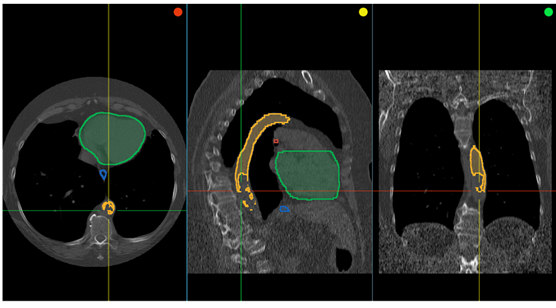

# Use ITKWidgets to display the AI-derived segmentations

Now, what if you want to actually access one of these segmentations? Here we show you how to:

*   Use `BigQuery` to pick a patient in NLST that has a segmentation
*   How to download this segmentation object using `gsutil`
*   How to find the corresponding ID for the raw CT data
*   How to query and download the raw CT data
*   How to use `ITKWidgets` to plot the CT data overlaid with the segmentation!


Let's first get a single AI-derived segmentation object from a patient. This query picks a single patient from NLST that has a segmentation. We also return the `gcs_url`, which holds the path to where the data is actually stored in the cloud. We need this to download the data!

In [ ]:
# We define a client and pass in our Google project id
client = bigquery.Client(project=project_name)
# This is the table we want to query, that holds the extracted metadata from DICOM files
table_id = ".".join(['bigquery-public-data', 'idc_v13', 'dicom_all'])
print(table_id)

query = f"""
  SELECT
    PatientID,
    SeriesDescription,
    # The gcs_url is where the actual object is stored in the cloud
    gcs_url
  FROM
    {table_id}
  WHERE
    # this is a segmentation object
    Modality = "SEG" AND
    # The NLST collection
    collection_id = "nlst"
  # We only want a single patient
  LIMIT 1
"""

# This converts the output to a pandas dataframe
seg_df = client.query(query).to_dataframe()
seg_df

bigquery-public-data.idc_v13.dicom_all


,PatientID,SeriesDescription,gcs_url
0,117950,3d_fullres-tta_nnU-Net_Segmentation,gs://public-datasets-idc/bd0fe641-962e-42e5-8e...


Now that we have the gcs_url to download, let's actually download this segmentation object from IDC. We use the `gsutil` package, which is provided by the Google Cloud Platform, to copy the object from the storage location to the Colab notebook.

In [ ]:
gcs_url = seg_df['gcs_url'][0]
output_seg_filename = "/content/seg.dcm"
!gsutil cp $gcs_url $output_seg_filename

Copying gs://public-datasets-idc/bd0fe641-962e-42e5-8ef2-315790e9f203.dcm...
- [1 files][  9.3 MiB/  9.3 MiB]                                                
Operation completed over 1 objects/9.3 MiB.                                      


Now that we've downloaded the segmentation object, we also need to download the corresponding CT files, as we'd like to overlay the two. For this, we'll need to obtain a field called the [SeriesInstanceUID](https://dicom.innolitics.com/ciods/cr-image/general-series/0020000e), think of this like a unique identifier. We use the [pydicom](https://) package to obtain the referenced SeriesInstanceUID of the segmentation object:

In [ ]:
dcm = pydicom.dcmread(output_seg_filename)
series_id = dcm.ReferencedSeriesSequence[0]['SeriesInstanceUID'].value
series_id

'1.2.840.113654.2.55.158518168216719541692843631994325394987'

Now that we have the appropriate id, we can use it do download all the raw CT files that correspond to it. For this we will use BigQuery again to get a list of the gcs_urls like before. We parameterize the query with the use of "@series_id".

In [ ]:
# We define the client and pass in the project id
client = bigquery.Client(project=project_name)

query_view = f"""
  SELECT
    # This is where the object is actually stored
    gcs_url
  FROM
    # This is the table in IDC that we query from
    `bigquery-public-data.idc_v13.dicom_all`
  WHERE
    # We want the data from a single series
    SeriesInstanceUID = @series_id;
  """

# We parameterize the query by passing in the series we're interested in
job_config = bigquery.QueryJobConfig(query_parameters=[
                                                       bigquery.ScalarQueryParameter("series_id", "STRING", series_id)
                                                       ])
result = client.query(query_view, job_config=job_config)
# We convert the output to a pandas dataframe
series_df = result.to_dataframe(create_bqstorage_client=True)
series_df


,gcs_url
0,gs://public-datasets-idc/7899e12d-4d97-4f1d-a8...
1,gs://public-datasets-idc/5af07f20-1130-4971-8f...
2,gs://public-datasets-idc/685680a6-5695-4bb2-92...
3,gs://public-datasets-idc/0cb211fe-a800-43d6-84...
4,gs://public-datasets-idc/17156298-28f7-4023-b3...
...,...
119,gs://public-datasets-idc/2a0edc6a-29e5-45ba-ba...
120,gs://public-datasets-idc/10f7fb20-4b5d-4b15-a0...
121,gs://public-datasets-idc/83d64923-9520-4640-ba...
122,gs://public-datasets-idc/dbb79833-047e-4f84-9b...


Now that we have all the locations of the files, we're ready to download them to the notebook. We concatenate all the urls in a single text file and pipe this to gsutil, instead of using a loop.

In [ ]:
# Create the text file to hold gsc_url
gs_file_path = "gcs_paths.txt"
series_df["gcs_url"].to_csv(gs_file_path, header = False, index = False)

# Download the series
download_path = "/content/raw"
if not os.path.isdir(download_path):
  os.mkdir(download_path)

!cat gcs_paths.txt | gsutil -m cp -I $download_path

Copying gs://public-datasets-idc/7899e12d-4d97-4f1d-a8a2-6e3394e28e7d.dcm...
Copying gs://public-datasets-idc/5af07f20-1130-4971-8f71-a825a43e9882.dcm...
Copying gs://public-datasets-idc/685680a6-5695-4bb2-9298-716c520f1e7f.dcm...
Copying gs://public-datasets-idc/0cb211fe-a800-43d6-84ad-54301d6ec80b.dcm...
Copying gs://public-datasets-idc/17156298-28f7-4023-b364-28b8273d43f5.dcm...
Copying gs://public-datasets-idc/81b5e306-6e43-45d8-881e-0844c93a37b3.dcm...
Copying gs://public-datasets-idc/8b96df75-57ea-4193-8723-d738fdc1b7f8.dcm...
Copying gs://public-datasets-idc/3d78dd34-70b7-4e2f-8a55-dad960de89c1.dcm...
Copying gs://public-datasets-idc/d9d087ba-1015-474f-9e84-38c11ab0ec1c.dcm...
Copying gs://public-datasets-idc/06b66fad-d2f9-4f6d-983a-c6462ee3be5d.dcm...
Copying gs://public-datasets-idc/7c414532-6ba8-44a3-9ea3-a0aba7a4e639.dcm...
Copying gs://public-datasets-idc/dcf6d11d-3641-4df4-95d0-81fee243df9d.dcm...
Copying gs://public-datasets-idc/5fad7075-7770-494a-b217-3bbb8ae5ff81.dcm...

Now that we have downloaded the segmentation file and the corresponding CT files, we are ready to view these data! Here we use `pydicom` and `pydicom_seg` to read in our CT and segmentation data, and use ITK (Insight ToolKit) to get information about our data and resample it so we can view it without memory problems.

New spacing = [2.656248, 2.656248, 2.500000032520325]
New size = [128, 128, 124]



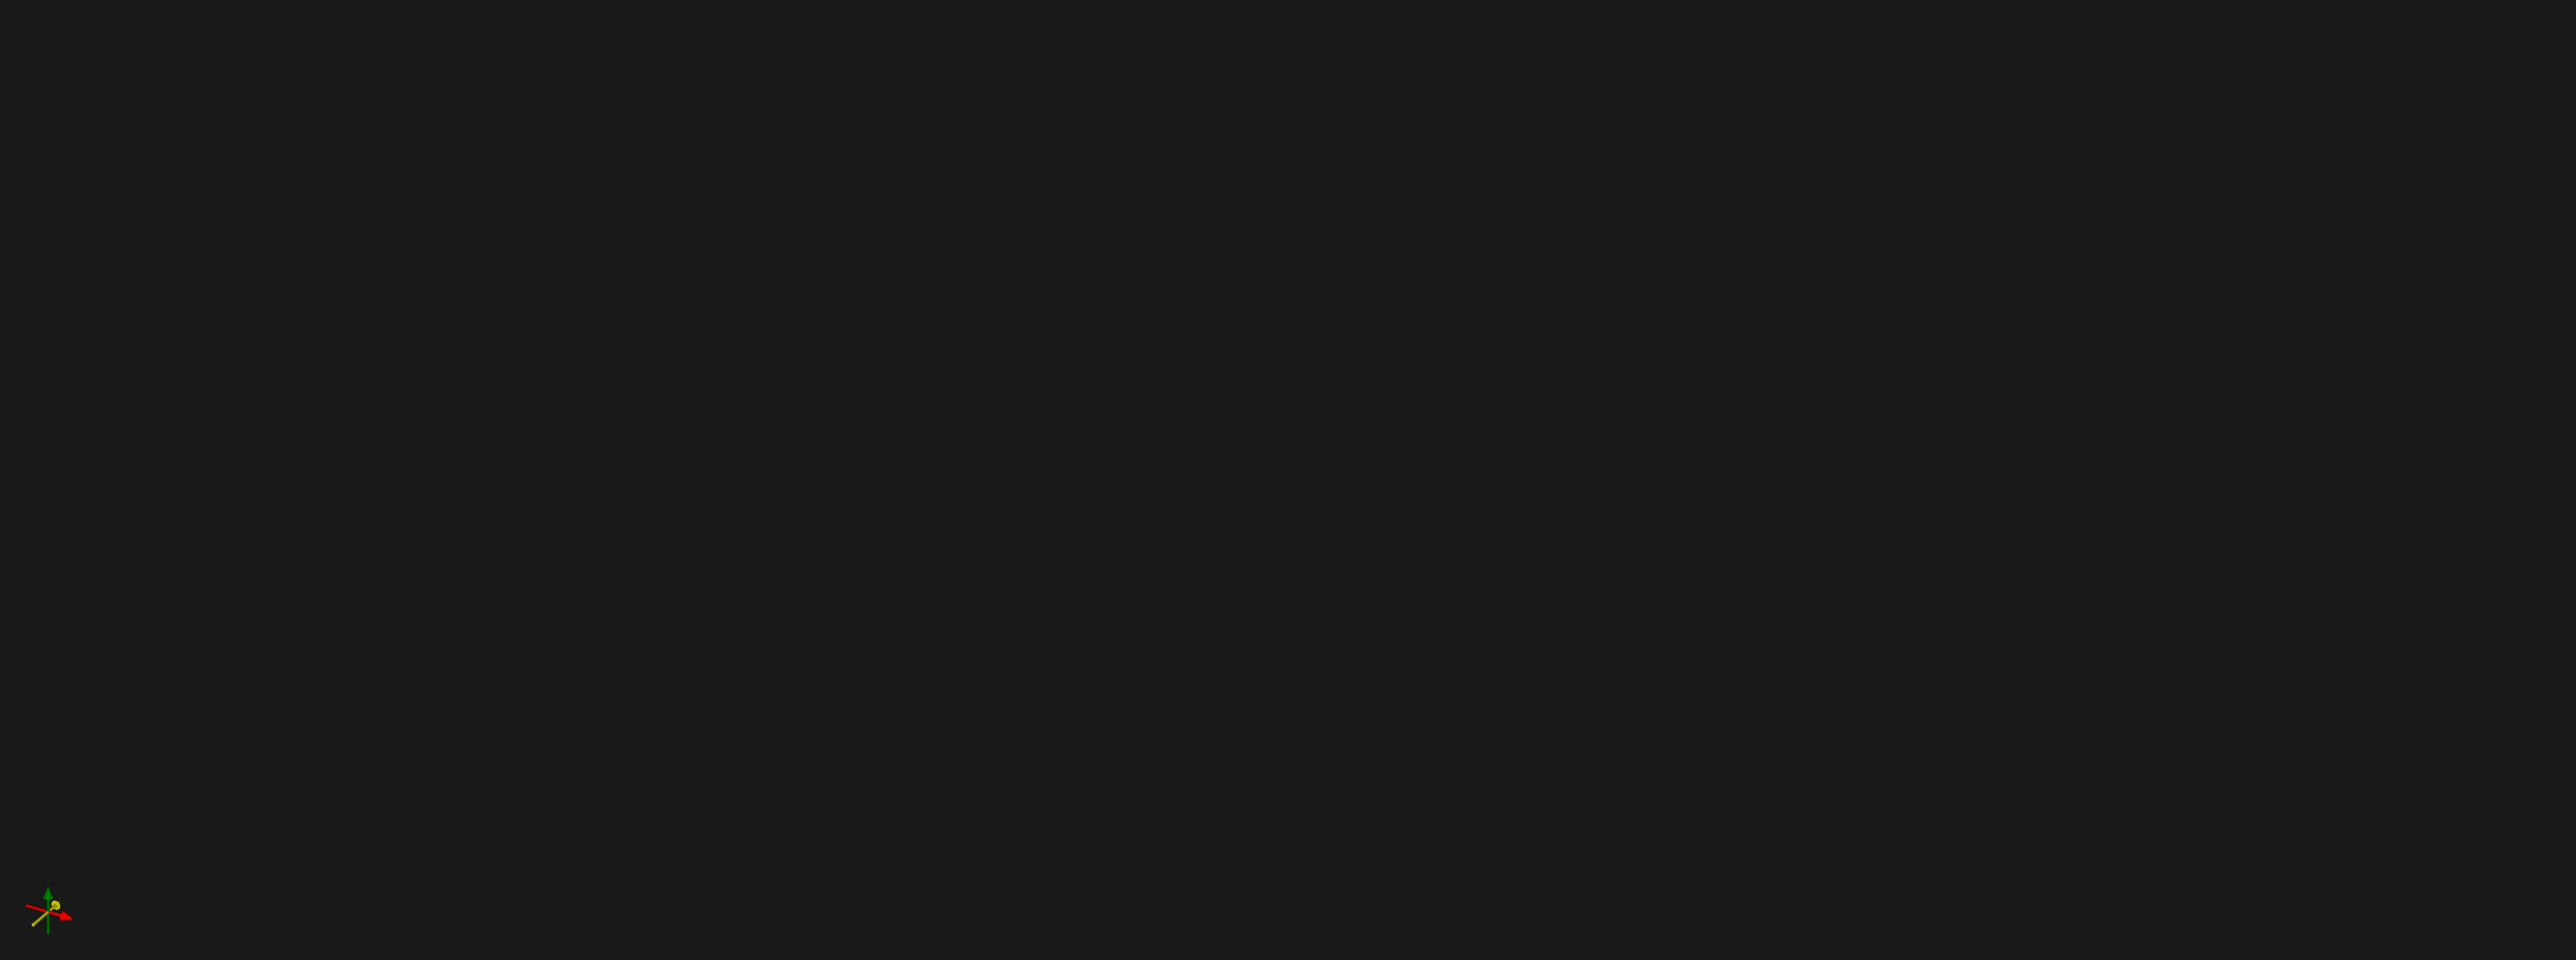
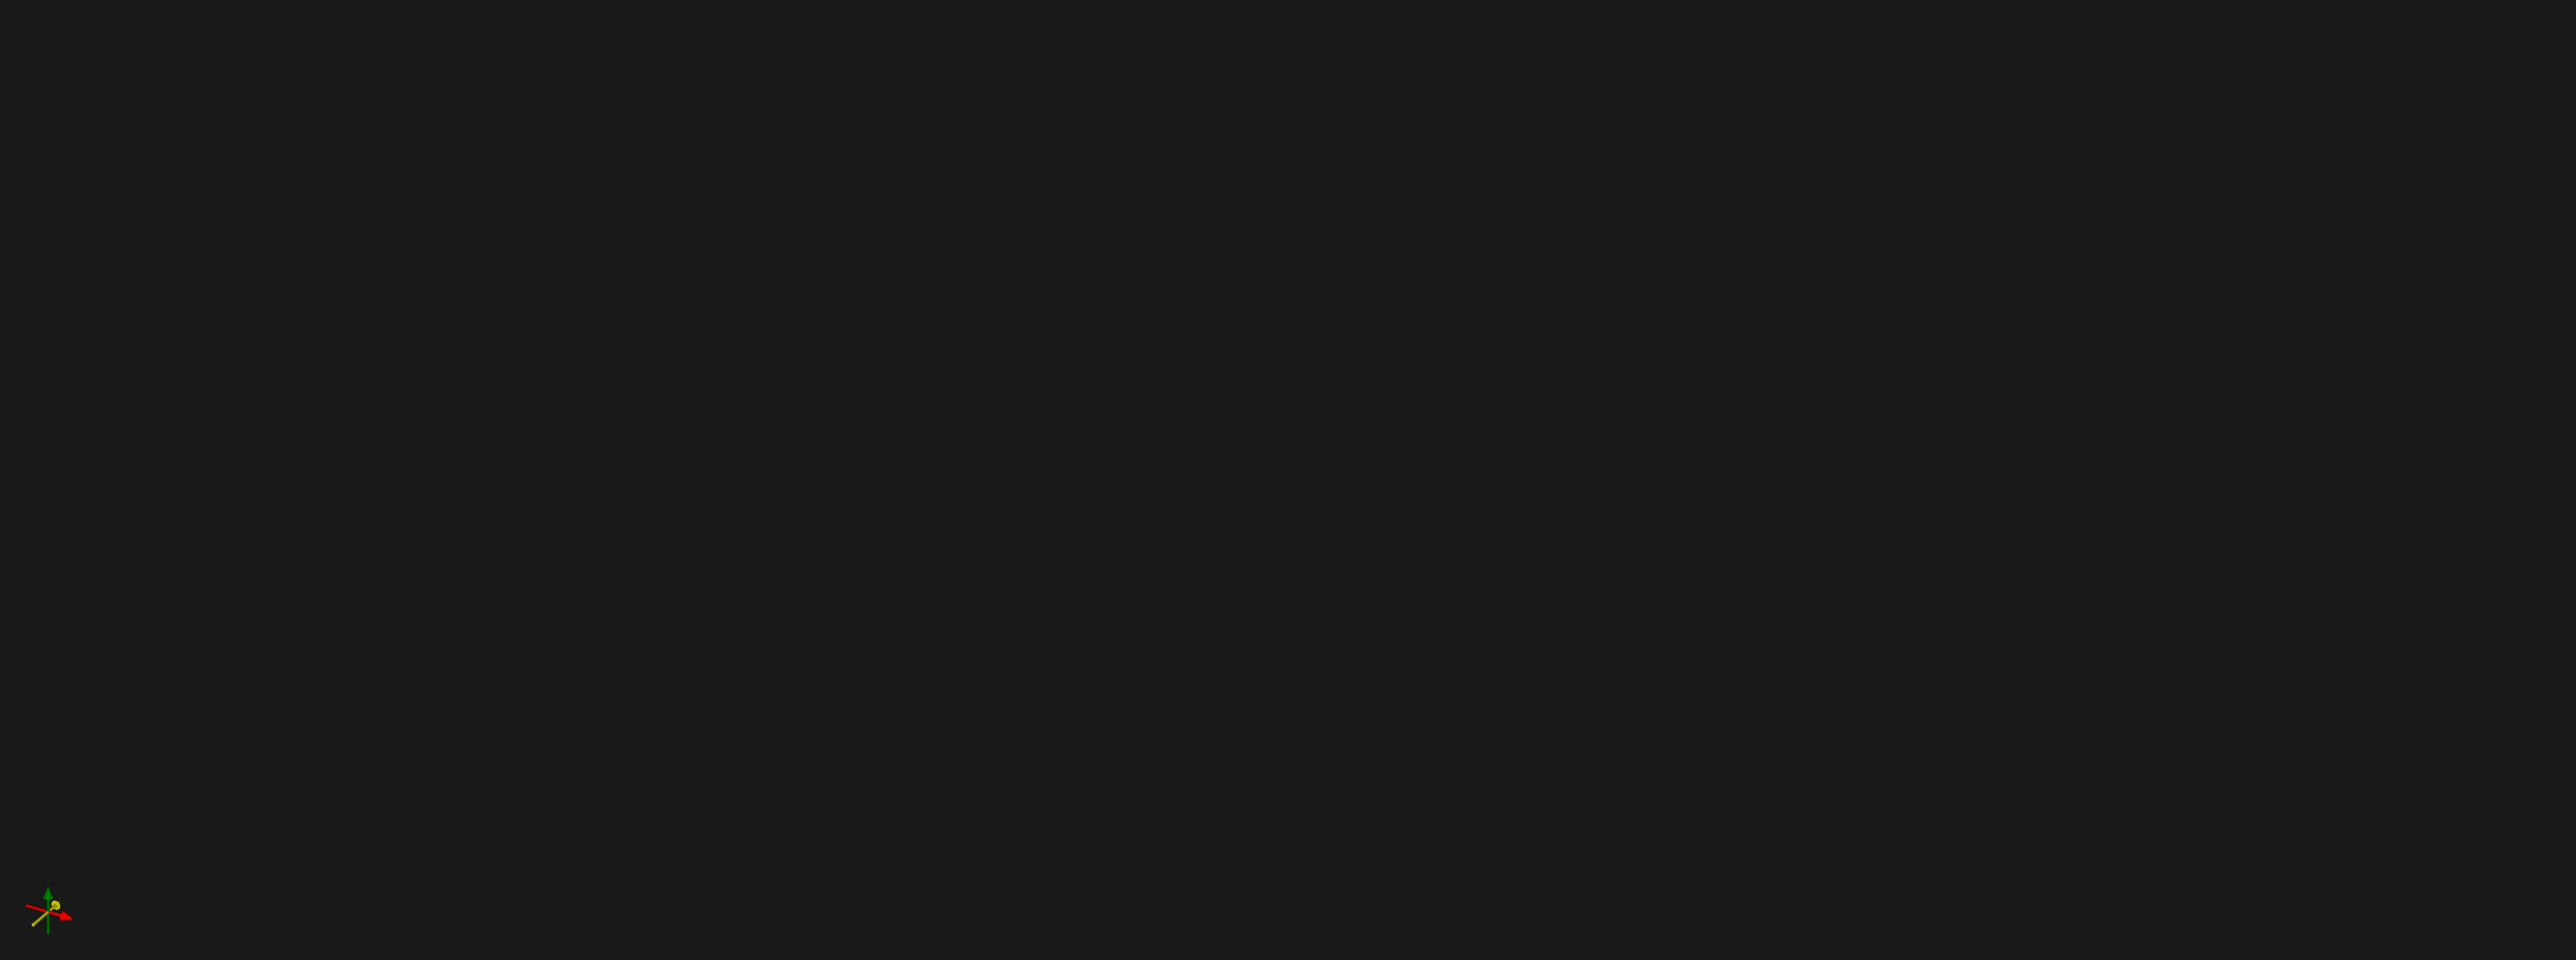

In [ ]:
#--- Read the DICOM CT series' objects and reconstruct them into a 3D ITK image. ---#

ct_dir = '/content/raw'
ct_image_large = itk.imread(ct_dir, itk.F)

# Read the DICOM SEG object using pydicom and pydicom_seg.
seg_file = '/content/seg.dcm'
seg_dicom = pydicom.dcmread(seg_file)
seg_reader = pydicom_seg.MultiClassReader()
seg_obj = seg_reader.read(seg_dicom)

# Convert the DICOM SEG object into an itk image, with correct voxel origin, spacing, and directions in physical space.
seg_image_large = itk.GetImageFromArray(seg_obj.data.astype(np.float32))
seg_image_large.SetOrigin(seg_obj.origin)
seg_image_large.SetSpacing(seg_obj.spacing)
seg_image_large.SetDirection(seg_obj.direction)

interpolator = itk.NearestNeighborInterpolateImageFunction.New(seg_image_large)
label_image_large = itk.resample_image_filter(Input=seg_image_large,
                                        Interpolator=interpolator,
                                        reference_image=ct_image_large,
                                        use_reference_image=True)


#--- This dataset is very big, so downsample the images before viewing ---#

# Subsample it in x and y dims
new_spacing = list(ct_image_large.GetSpacing())
new_spacing[:2] = [x*4 for x in new_spacing[:2]]
new_size = list(ct_image_large.GetLargestPossibleRegion().GetSize())
new_size[:2] = [x//4 for x in new_size[:2]]
ct_image = itk.resample_image_filter(Input=ct_image_large,
                                     output_spacing=new_spacing,
                                     output_origin=ct_image_large.GetOrigin(),
                                     output_direction=ct_image_large.GetDirection(),
                                     size=new_size)
labelmap_interpolator = itk.NearestNeighborInterpolateImageFunction.New(InputImage=seg_image_large)
seg_image = itk.resample_image_filter(Input=seg_image_large,
                                    Interpolator=labelmap_interpolator,
                                    ReferenceImage=ct_image,
                                    UseReferenceImage=True)
print(f"New spacing = {new_spacing}")
print(f"New size = {new_size}")

# --- View downsampled volume and label overlay --- #

viewer = view(image=ct_image, label_image=seg_image)
viewer.set_ui_collapsed(False)

viewer.set_image_gradient_opacity(0.45)
viewer.set_image_gradient_opacity_scale(0.35)
viewer.set_label_image_blend(0.65)

viewer.set_background_color([0.1,0.1,0.1])
viewer.set_image_color_map("Grayscale")
viewer.set_image_color_range([-1727,273])
viewer.set_label_image_blend(0.45)
viewer.set_view_mode('ZPlane')

# What's next?

We hope that you've learned how to interact with and explore data that's part of IDC. We hope that in the future, you will be able to:

*   Use the techniques that we demonstrated for exploration of your own data
*   Use AI-generated annotations in IDC for your own model development and hypothesis generation
*   Make the code and data you generate transparent and reproducible so other researchers can benefit

**How can I learn more about the AI-derived annotations that we explored in this notebook?**

To learn more about the AI-derived annotations that we focused on in this article, see the following resources:

*   [Publication](https://arxiv.org/abs/2306.00150) in arxiv
*   [Google Colaboratory notebooks](https://github.com/ImagingDataCommons/nnU-Net-BPR-annotations/tree/main) to show how to interact with the data
*   Exploration of data in the [IDC portal](https://portal.imaging.datacommons.cancer.gov/explore/filters/?analysis_results_id=nnU-Net-BPR-annotations)
*   Exploration of data in a [dashboard](https://lookerstudio.google.com/u/0/reporting/a9ead556-4f23-4139-a008-1135772b358a/page/p_wsm498cc3c?s=idUgo-ggtN0)
*   Download of data in [Zenodo](https://zenodo.org/record/7975081)

**How can I learn more about Imaging Data Commons?**

For more information about IDC, please refer to these resources:

*   [Publication](https://aacrjournals.org/cancerres/article/81/16/4188/670283) in the Cancer Research journal
*   [User guide](https://learn.canceridc.dev/) and documentation
*   For [tutorials](https://github.com/ImagingDataCommons/IDC-Tutorials) in the form of Google Colaboratory notebooks
*   The [portal](https://portal.imaging.datacommons.cancer.gov/) for the exploration of data
*   A [dashboard](https://lookerstudio.google.com/u/0/reporting/ab96379c-e134-414f-8996-188e678f1b70/page/KHtxB/preview) for interactive exploration of the data available in IDC

---